In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/ranks')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import logging
import torch
import pickle
import pandas as pd
import matplotlib.pylab as pylab
from torch.utils.data import Dataset, Subset, DataLoader
from time import time

from pytorch.job_runners.abc_parameterizations.abc_runner import ABCRunner
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.results import *
from pytorch.configs.model import ModelConfig
from utils.nn import squared_trace_rank, frob_spec_rank

## Set variables

In [6]:
L = 6
WIDTH = 1024
BASE_LR = 0.01
BATCH_SIZE = 512
BIAS = False
N_TRIALS = 5
N_WARMUP_STEPS = 1
MODEL_NAME = 'fc_muP' # 'fc_ipllr', 'standard_fc_ip', 'fc_muP'
DATASET = 'mnist'  # 'mnist', 'cifar10'
SEED = 42

CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations')
EXPERIMENTS_DIR = 'experiments'
MODEL_NAME = 'fc_ipllr'
CONFIG_FILE = 'fc_ipllr.yaml'

FONTSIZE = 12
FIGSIZE = (10, 6)

ACT_KEY_TO_NAME = {'relu': 'ReLU',
                   'gelu': 'GeLU',
                   'elu': 'ELU',
                   'tanh': 'tanh'}


set_random_seeds(SEED)
experiments_dir = os.path.join(ROOT, 'experiments')
base_experiment = '{}_{}'.format(MODEL_NAME, DATASET)
fig_dir = os.path.join(ROOT, FIGURES_DIR)

params = {'legend.fontsize': FONTSIZE,
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE}
pylab.rcParams.update(params)

## Data and config

In [7]:
base_lr = BASE_LR
batch_size = BATCH_SIZE
dataset = DATASET
download = False

model_name = '{}_{}'.format(MODEL_NAME, dataset)
config_path = os.path.join(CONFIG_PATH, '{}.yaml'.format(model_name))
config_dict = read_yaml(config_path)

# define corresponding directory in experiments folder
base_experiment_path = os.path.join(ROOT, EXPERIMENTS_DIR, model_name)  # base experiment folder

# Load data & define models
logger = logging.getLogger()
logger.info('Loading data ...')
if dataset == 'mnist':
    from utils.dataset.mnist import load_data
elif dataset == 'cifar10':
    from utils.dataset.cifar10 import load_data
elif dataset == 'cifar100':
    # TODO : add cifar100 to utils.dataset
    pass
else:
    error = ValueError("dataset must be one of ['mnist', 'cifar10', 'cifar100'] but was {}".format(dataset))
    logger.error(error)
    raise error

# prepare data
training_dataset, _ = load_data(download=download, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=BATCH_SIZE)

batches = list(train_data_loader)

In [8]:
config_dict['architecture']['width'] = WIDTH
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = BASE_LR
config_dict['training']['batch_size'] = BATCH_SIZE
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}

In [9]:
models = dict()
for activation in ACT_KEY_TO_NAME.keys():
    config_dict['activation']['name'] = activation
    config = ModelConfig(config_dict=config_dict)
    models[activation] = [FcIPLLR(config, lr_calibration_batches=batches[:2], 
                                  n_warmup_steps=N_WARMUP_STEPS) for _ in range(N_TRIALS)]

In [10]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)
print(full_x.size(), full_y.size())

torch.Size([60000, 784]) torch.Size([60000])


## Train models for one step

In [11]:
x, y = batches[0]
with torch.no_grad():
    x_ = x.detach().clone()
hs = dict()
xs = dict()
for activation in models.keys():
    hs[activation] = []
    xs[activation] = []
    for model in models[activation]:
        model.train()
        hs_ = []
        xs_ = []
        
        h = (model.width ** (-model.a[0])) * model.input_layer.forward(x_)
        h.retain_grad()
        x = model.activation(h)
        x.retain_grad()
        
        hs_.append(h)
        xs_.append(x)
        
        for l, layer in enumerate(model.intermediate_layers):  
            h = (model.width ** (-model.a[l+1])) * layer.forward(x)  
            h.retain_grad()
            x = model.activation(h)
            x.retain_grad()
            
            hs_.append(h)
            xs_.append(x)
            

        h = (model.width ** (-model.a[model.n_layers-1])) * model.output_layer.forward(x)
        with torch.no_grad():
            y_hat = model.forward(x_)
            torch.testing.assert_allclose(h, y_hat, atol=1e-3, rtol=1e-4)
        
        loss = model.loss(h, y)
        loss.backward()
        model.optimizer.step()
        if hasattr(model, "scheduler") and model.scheduler is not None:
            model.scheduler.step()
        
        hs[activation].append(hs_)
        xs[activation].append(xs_)
        model.eval()

## Compute ranks on a large batch fro IP-LLR at time $t=1$

In [12]:
n_samples = 5000
x_b = full_x[:n_samples, :]
y_b = full_y[:n_samples]

In [13]:
torch_rank_hs = dict()
torch_rank_xs = dict()

trace_rank_hs = dict()
trace_rank_xs = dict()

frob_rank_hs = dict()
frob_rank_xs = dict()

In [14]:
start = time()
with torch.no_grad():
    for activation in models.keys():
        torch_rank_hs_ = []
        torch_rank_xs_ = []
        
        trace_rank_hs_ = []
        trace_rank_xs_ = []
        
        frob_rank_hs_ = []
        frob_rank_xs_ = []
        
        for model in models[activation]:
            x = x_b
            model.eval()
            
            torch_rank_model_hs = dict()
            torch_rank_model_xs = {'0': torch.matrix_rank(x).item()}
            
            #trace_rank_model_hs = dict()
            #trace_rank_model_xs = {'0': squared_trace_rank(x)}
            
            #frob_rank_model_hs = dict()
            #frob_rank_model_xs = {'0': frob_spec_rank(x)}
            
            h = (model.width ** (-model.a[0])) * model.input_layer.forward(x)
            x = model.activation(h)
            
            torch_rank_model_hs['1'] = torch.matrix_rank(h).item()
            torch_rank_model_xs['1'] = torch.matrix_rank(x).item()
            
            #trace_rank_model_hs['1'] = squared_trace_rank(h)
            #trace_rank_model_xs['1'] = squared_trace_rank(x)
            
            #frob_rank_model_hs['1'] = frob_spec_rank(h)
            #frob_rank_model_xs['1'] = frob_spec_rank(x)
            
            for l, layer in enumerate(model.intermediate_layers):  
                h = (model.width ** (-model.a[l+1])) * layer.forward(x)  
                x = model.activation(h)
                
                torch_rank_model_hs[str(l+2)] = torch.matrix_rank(h).item()
                torch_rank_model_xs[str(l+2)] = torch.matrix_rank(x).item()
            
            h = (model.width ** (-model.a[model.n_layers-1])) * model.output_layer.forward(x)
            y_hat = model.forward(x_b)
            torch.testing.assert_allclose(h, y_hat, atol=1e-3, rtol=1e-4)
                #trace_rank_model_hs[str(l+2)] = squared_trace_rank(h)
                #trace_rank_model_xs[str(l+2)] = squared_trace_rank(x)
                
                #frob_rank_model_hs[str(l+2)] = frob_spec_rank(h)
                #frob_rank_model_xs[str(l+2)] = frob_spec_rank(x)


            torch_rank_hs_.append(torch_rank_model_hs)
            torch_rank_xs_.append(torch_rank_model_xs)
            
            #trace_rank_hs_.append(trace_rank_model_hs)
            #trace_rank_xs_.append(trace_rank_model_xs)
            
            #frob_rank_hs_.append(frob_rank_model_hs)
            #frob_rank_xs_.append(frob_rank_model_xs)

        torch_rank_hs[activation] = torch_rank_hs_
        torch_rank_xs[activation] = torch_rank_xs_
        
        #trace_rank_hs[activation] = trace_rank_hs_
        #trace_rank_xs[activation] = trace_rank_xs_
        
        #frob_rank_hs[activation] = frob_rank_hs_
        #frob_rank_xs[activation] = frob_rank_xs_
end = time()
print('Time for computing all ranks on full training set: {:.2f} minutes'.format((end - start) / 60))

Time for computing all ranks on full training set: 2.72 minutes


In [15]:
torch_rank_hs

{'relu': [{'1': 901, '2': 198, '3': 13, '4': 3, '5': 1, '6': 1},
  {'1': 896, '2': 200, '3': 11, '4': 3, '5': 2, '6': 1},
  {'1': 900, '2': 202, '3': 11, '4': 3, '5': 2, '6': 1},
  {'1': 897, '2': 195, '3': 13, '4': 3, '5': 2, '6': 1},
  {'1': 897, '2': 204, '3': 12, '4': 3, '5': 2, '6': 1}],
 'gelu': [{'1': 895, '2': 513, '3': 18, '4': 16, '5': 14, '6': 10},
  {'1': 898, '2': 505, '3': 20, '4': 18, '5': 15, '6': 13},
  {'1': 896, '2': 506, '3': 17, '4': 15, '5': 11, '6': 11},
  {'1': 895, '2': 500, '3': 17, '4': 18, '5': 15, '6': 13},
  {'1': 894, '2': 505, '3': 20, '4': 19, '5': 18, '6': 15}],
 'elu': [{'1': 892, '2': 135, '3': 17, '4': 14, '5': 12, '6': 12},
  {'1': 896, '2': 121, '3': 17, '4': 12, '5': 10, '6': 9},
  {'1': 892, '2': 117, '3': 14, '4': 13, '5': 11, '6': 12},
  {'1': 896, '2': 130, '3': 14, '4': 14, '5': 10, '6': 9},
  {'1': 896, '2': 122, '3': 13, '4': 10, '5': 10, '6': 9}],
 'tanh': [{'1': 894, '2': 85, '3': 17, '4': 12, '5': 8, '6': 7},
  {'1': 890, '2': 80, '3': 

In [16]:
torch_rank_xs

{'relu': [{'0': 1024, '1': 1021, '2': 288, '3': 15, '4': 3, '5': 1, '6': 1},
  {'0': 1024, '1': 1019, '2': 260, '3': 14, '4': 3, '5': 2, '6': 1},
  {'0': 1024, '1': 1020, '2': 270, '3': 13, '4': 3, '5': 2, '6': 1},
  {'0': 1024, '1': 1023, '2': 257, '3': 12, '4': 3, '5': 2, '6': 1},
  {'0': 1024, '1': 1019, '2': 288, '3': 17, '4': 3, '5': 2, '6': 1}],
 'gelu': [{'0': 1024, '1': 1020, '2': 549, '3': 56, '4': 37, '5': 27, '6': 20},
  {'0': 1024, '1': 1021, '2': 588, '3': 68, '4': 39, '5': 27, '6': 22},
  {'0': 1024, '1': 1019, '2': 549, '3': 48, '4': 35, '5': 25, '6': 18},
  {'0': 1024, '1': 1019, '2': 564, '3': 57, '4': 39, '5': 30, '6': 23},
  {'0': 1024, '1': 1022, '2': 569, '3': 54, '4': 42, '5': 33, '6': 20}],
 'elu': [{'0': 1024, '1': 1024, '2': 264, '3': 87, '4': 61, '5': 45, '6': 38},
  {'0': 1024, '1': 1024, '2': 240, '3': 96, '4': 47, '5': 31, '6': 31},
  {'0': 1024, '1': 1024, '2': 224, '3': 70, '4': 52, '5': 44, '6': 40},
  {'0': 1024, '1': 1024, '2': 266, '3': 66, '4': 52, '

In [17]:
ranks_df = pd.DataFrame(columns=['layer', 'rank', 'type', 'activation'])

In [18]:
idx = 0
for i in range(N_TRIALS):
    for activation in torch_rank_hs.keys():
        h_ranks = torch_rank_hs[activation][i]
        x_ranks = torch_rank_xs[activation][i]
        for l in range(1, L+1):
            ranks_df.loc[idx, ['layer', 'rank', 'type', 'activation']] = \
                [l, h_ranks[str(l)], '$h^l_1$', ACT_KEY_TO_NAME[activation]]
            ranks_df.loc[idx+1, ['layer', 'rank', 'type', 'activation']] = \
                [l, x_ranks[str(l)], '$x^l_1$', ACT_KEY_TO_NAME[activation]]
            idx += 2

In [19]:
ranks_df.loc[:, 'rank'] = ranks_df.loc[:, 'rank'].astype(float)

[None]

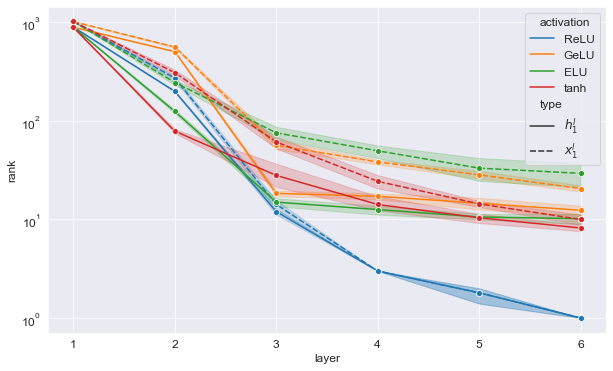

In [20]:
df = ranks_df
plt.figure(figsize=FIGSIZE)

g = sns.lineplot(x="layer", y="rank", hue="activation", style='type',  data=df, marker='o')

g.set(yscale='log')

# plt.show()

#fig_path = os.path.join(fig_dir, '{}_x_h.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

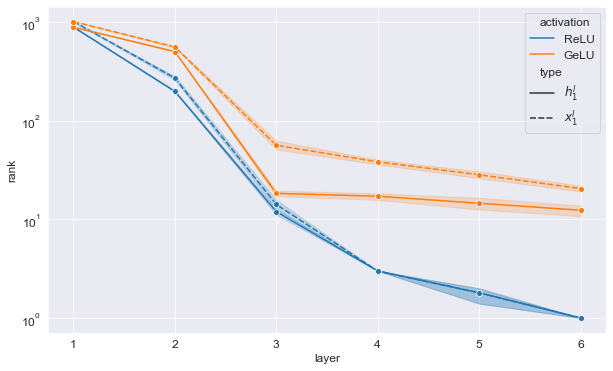

In [21]:
df = ranks_df.loc[ranks_df.activation.isin(['ReLU', 'GeLU'])]
plt.figure(figsize=FIGSIZE)

g = sns.lineplot(x="layer", y="rank", hue="activation", style='type',  data=df, marker='o')

g.set(yscale='log')

# plt.show()

#fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

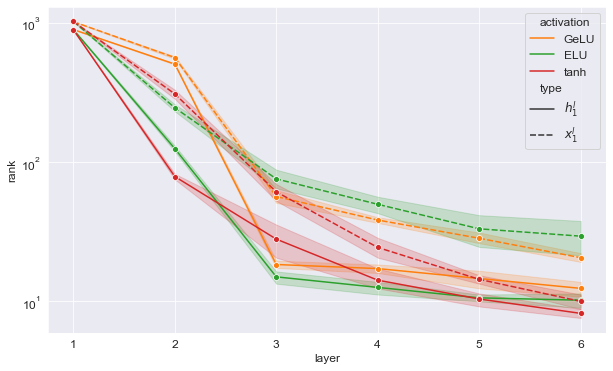

In [22]:
activations = ['GeLU', 'ELU', 'tanh']
df = ranks_df.loc[ranks_df.activation.isin(activations)]
plt.figure(figsize=FIGSIZE)

palette = sns.color_palette()[1:len(activations) + 1]
g = sns.lineplot(x="layer", y="rank", hue="activation", style='type',  data=df, marker='o', palette=palette)

g.set(yscale='log')

plt.show()

#fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)